In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from scipy import integrate, sparse
from scipy.stats import norm, multivariate_normal
from scipy.optimize import brentq, fsolve, minimize_scalar

In [2]:
# Parameters (WTI Sep '23 (CLU23) on July 07 2023)
futures_price = 73.77
strike_price = 80
risk_free_rate = 0.05235
time_to_maturity = 40/365
vol_black = 0.32
vol_bachelier = vol_black * futures_price

## Bachelier (1900)
\begin{align*}
& dF_t = \sigma_a dW_t \\\\
& C_{BC}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [(F-K)N(m_a) + \sigma_a\sqrt{\tau}n(m_a)] \\
& P_{BC}(F, K,\sigma_a, r,\tau) = e^{-r\tau} \ [(K-F)(1-N(m_a)) + \sigma_a\sqrt{\tau}n(m_a)] \\\\
&\textit{ where} \\
&\ m_a = \frac{F-K}{\sigma_a \sqrt{\tau}}
\end{align*}

In [3]:
# Bachelier (1900)

class Bachelier:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Bachelier formula
      return call/put option price
      '''
      # default parameter (to compute implied vol)
      if vol == None:
          vol = self.vol

      m = (self.F - K) / (vol * self.tau**0.5)
      if option_type == 'call':
          return np.exp(-self.r * self.tau) * ((self.F - K) * norm.cdf(m) + vol * self.tau**0.5 * norm.pdf(m))
      elif option_type == 'put':
          return np.exp(-self.r * self.tau) * ((K - self.F) * (1 - norm.cdf(m)) + vol * self.tau**0.5 * norm.pdf(m))


    def simulate_F(self, paths = 100000, steps = 2):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''
      # initialize vectors
      arr_F = np.zeros((paths, steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      t_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0, steps-1):
        arr_F[:,t+1] = arr_F[:,t] + self.vol * dt**0.5 * arr_w[:,t]

      return arr_F, t_vec


    def implicit_FD(self, K, option_type = 'call'):
      '''
      The implicit finite difference
      return call/put option price
      '''
      # PDE: V_t + aV_ff + bV_f + cV = 0
      a = lambda f : 0.5 * self.vol**2
      b = lambda f : 0
      c = lambda f : -self.r

      # Grid Parameters
      f_max = self.F + 100                                                        # space upper boundary
      f_min = self.F - 100                                                        # space lower boundary
      M = int(10*(f_max-f_min)) + 1                                               # the number of space steps
      N = int(100*252*self.tau)                                                   # the number of time steps

      # Grid Construction
      arr_f, df = np.linspace(f_min, f_max, M, retstep=True)                      # space discretization
      arr_t, dt = np.linspace(0, self.tau, N, retstep=True)                       # time discretization
      V = np.zeros((M, N))                                                        # grid initialization
      if option_type == 'call':
          V[:,0] = np.maximum(0, arr_f - K)                                       # European call option payoff (terminal condition)
          V[0,:] = 0                                                              # boundary condition
          V[-1,:] = (f_max - K) * np.exp(-self.r*arr_t)                           # boundary condition
      elif option_type == 'put':
          V[:,0] = np.maximum(0, K - arr_f)                                       # European put option payoff (terminal condition)
          V[0,:] = (K - f_min)* np.exp(-self.r*arr_t)                             # boundary condition
          V[-1,:] = 0                                                             # boundary condition

      # Tri-diagonal Matrix Construction
      alpha = lambda f : -a(f)*dt/df**2 + b(f)*dt/2/df
      beta = lambda f : 1 + 2*a(f)*dt/df**2 - c(f)*dt
      gamma = lambda f : -a(f)*dt/df**2 - b(f)*dt/2/df

      D = np.zeros(shape = (M-2,M-2))
      D[0,0], D[0,1], D[-1,-2], D[-1,-1] = beta(arr_f[1]), gamma(arr_f[1]), alpha(arr_f[-2]), beta(arr_f[-2])
      for m in range(1, M-3):
          D[m,m-1], D[m,m], D[m,m+1] = alpha(arr_f[m+1]), beta(arr_f[m+1]), gamma(arr_f[m+1])
      D = sparse.csr_matrix(D)

      # Grid Computation
      rem = np.zeros(shape = (M-2,))
      for n in range(1,N):
          rem[0], rem[-1] = alpha(arr_f[1])*V[0,n-1], gamma(arr_f[-2])*V[-1,n-1]
          V[1:-1,n] =  sparse.linalg.spsolve(D, V[1:-1, n-1] - rem)

      return V[ round( (self.F - f_min)/df), -1]


In [4]:
# Bachelier formula
bachelier = Bachelier(futures_price, vol_bachelier, risk_free_rate, time_to_maturity)
bachelier_call = bachelier.option_pricer(K = strike_price, option_type = 'call')
bachelier_put = bachelier.option_pricer(K = strike_price, option_type = 'put')

print(f'Bachelier formula:')
print(f'call is {bachelier_call:.4f}')
print(f'put is {bachelier_put:.4f}')

Bachelier formula:
call is 0.9386
put is 7.1330


In [5]:
# Monte Carlo simulation
paths = 1000000
arr_F, _ = bachelier.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
bachelier_call_mc, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
bachelier_put_mc, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation:')
print(f'call is {bachelier_call_mc:.4f} with standard error {ste_call:.6f}')
print(f'put is {bachelier_put_mc:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation:
call is 0.9419 with standard error 0.002489
put is 7.1293 with standard error 0.006394


In [6]:
# Finite difference method (implicit)
bachelier_call_df = bachelier.implicit_FD(K = strike_price, option_type = 'call')
bachelier_put_fd = bachelier.implicit_FD(K = strike_price, option_type = 'put')
print(f'Finite difference method (implicit):')
print(f'call is {bachelier_call_df:.4f}')
print(f'put is {bachelier_put_fd:.4f}')

Finite difference method (implicit):
call is 0.9386
put is 7.1329


## Black (1976)
\begin{align*}
& dF_t = \sigma_G F_tdW_t \\\\
& C_{BL}(F, K,\sigma_G, r,\tau) = e^{-r\tau} \ [FN(m_G + \frac{\sigma_G\sqrt{\tau}}{2}) - KN(m_G - \frac{\sigma_G\sqrt{\tau}}{2})] \\
& P_{BL}(F, K,\sigma_G, r,\tau) = e^{-r\tau} \ [K(1-N(m_G - \frac{\sigma_G\sqrt{\tau}}{2})) - F(1-N(m_G + \frac{\sigma_G\sqrt{\tau}}{2}))] \\\\
& \textit{ where} \\
&\ m_G = \frac{ln(F-K)}{\sigma_G \sqrt{\tau}}
\end{align*}

In [7]:
# Black (1976)

class Black:
    def __init__(self, F, vol, r, tau):
      self.F = F
      self.vol = vol
      self.r = r
      self.tau = tau


    def option_pricer(self, K, vol = None, option_type = 'call'):
      '''
      Black formula
      return call/put option price
      '''
      # default parameter (to compute implied vol)
      if vol == None:
          vol = self.vol

      m = np.log(self.F / K) / (vol * self.tau**0.5)
      if option_type == 'call':
          return np.exp(-self.r * self.tau) * ( self.F * norm.cdf(m + 0.5*vol*self.tau**0.5) -
                                                      K * norm.cdf(m - 0.5*vol*self.tau**0.5))
      elif option_type == 'put':
          return np.exp(-self.r * self.tau) * ( K * (1 - norm.cdf(m - 0.5*vol*self.tau**0.5)) -
                                                      self.F * (1 - norm.cdf(m + 0.5*vol*self.tau**0.5)))


    def simulate_F(self, paths = 100000, steps = 2):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''
      # initialize vectors
      arr_F = np.zeros((paths, steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      t_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0, steps-1):
          arr_F[:,t+1] = arr_F[:,t] * np.exp( -0.5 * self.vol**2 * dt + self.vol * dt**0.5 * arr_w[:,t] )

      return arr_F, t_vec


    def implicit_FD(self, K, option_type = 'call'):
      '''
      The implicit finite difference
      return call/put option price
      '''
      # PDE: V_t + aV_ff + bV_f + cV = 0
      a = lambda f : 0.5 * (f * self.vol)**2
      b = lambda f : 0
      c = lambda f : -self.r

      # Grid Parameters
      f_max = self.F + 100                                                        # space upper boundary
      f_min = self.F - 100                                                        # space lower boundary
      M = int(8*(f_max-f_min)) + 1                                                # the number of space steps
      N = int(100*252*self.tau)                                                   # the number of time steps

      # Grid Construction
      arr_f, df = np.linspace(f_min, f_max, M, retstep=True)                      # space discretization
      arr_t, dt = np.linspace(0, self.tau, N, retstep=True)                       # time discretization
      V = np.zeros((M, N))                                                        # grid initialization
      if option_type == 'call':
          V[:,0] = np.maximum(0, arr_f - K)                                       # European call option payoff (terminal condition)
          V[0,:] = 0                                                              # boundary condition
          V[-1,:] = (f_max - K) * np.exp(-self.r*arr_t)                           # boundary condition
      elif option_type == 'put':
          V[:,0] = np.maximum(0, K - arr_f)                                       # European put option payoff (terminal condition)
          V[0,:] = (K - f_min)* np.exp(-self.r*arr_t)                             # boundary condition
          V[-1,:] = 0                                                             # boundary condition

      # Tri-diagonal Matrix Construction
      alpha = lambda f : -a(f)*dt/df**2 + b(f)*dt/2/df
      beta = lambda f : 1 + 2*a(f)*dt/df**2 - c(f)*dt
      gamma = lambda f : -a(f)*dt/df**2 - b(f)*dt/2/df

      D = np.zeros(shape = (M-2,M-2))
      D[0,0], D[0,1], D[-1,-2], D[-1,-1] = beta(arr_f[1]), gamma(arr_f[1]), alpha(arr_f[-2]), beta(arr_f[-2])
      for m in range(1, M-3):
          D[m,m-1], D[m,m], D[m,m+1] = alpha(arr_f[m+1]), beta(arr_f[m+1]), gamma(arr_f[m+1])
      D = sparse.csr_matrix(D)

      # Grid Computation
      rem = np.zeros(shape = (M-2,))
      for n in range(1,N):
          rem[0], rem[-1] = alpha(arr_f[1])*V[0,n-1], gamma(arr_f[-2])*V[-1,n-1]
          V[1:-1,n] =  sparse.linalg.spsolve(D, V[1:-1, n-1] - rem)

      return V[ round( (self.F - f_min)/df), -1]


In [8]:
# Black formula
black = Black(futures_price, vol_black, risk_free_rate, time_to_maturity)
black_call = black.option_pricer(K = strike_price, option_type = 'call')
black_put = black.option_pricer(K = strike_price, option_type = 'put')

print(f'Black formula:')
print(f'call is {black_call:.4f}')
print(f'put is {black_put:.4f}')

Black formula:
call is 1.0327
put is 7.2270


In [9]:
# Monte Carlo simulation
paths = 1000000
arr_F, _ = black.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
black_call_mc, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
black_put_mc, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation:')
print(f'call is {black_call_mc:.4f} with standard error {ste_call:.6f}')
print(f'put is {black_put_mc:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation:
call is 1.0305 with standard error 0.002822
put is 7.2285 with standard error 0.006147


In [10]:
# Finite difference method (implicit)
black_call_df = black.implicit_FD(K = strike_price, option_type = 'call')
black_put_fd = black.implicit_FD(K = strike_price, option_type = 'put')
print(f'Finite difference method (implicit):')
print(f'call is {black_call_df:.4f}')
print(f'put is {black_put_fd:.4f}')

Finite difference method (implicit):
call is 1.0326
put is 7.2269


## Heston (1993)
\begin{cases}
dF_t = \sqrt{v_t} F_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t\\
dW^1_tdW^2_t = \rho dt
\end{cases}

In [11]:
# Heston (1993)

def cf(u, tau, mu, rho, v0, theta, kappa, sigma):
    '''
    Heston characteristic function in Schoutens (2004)
    '''
    d = ((kappa - rho*sigma*u*1j)**2 + sigma**2*(1j*u + u**2))**0.5
    g = (kappa - rho*sigma*u*1j - d)/(kappa - rho*sigma*u*1j + d)
    cf_ = np.exp( 1j*u*mu*tau +
                 theta*kappa*sigma**-2*((kappa - rho*sigma*u*1j - d)*tau - 2*np.log((1 - g*np.exp(-d*tau))/( 1 - g))) +
                 v0*sigma**-2*(kappa - rho*sigma*u*1j - d)*(1 - np.exp(-d*tau))/(1 - g*np.exp(-d*tau)) )
    return cf_


class Heston:
    def __init__(self, F, v0, theta, kappa, sigma, rho,  r, tau):
      self.F = F
      self.v0 = v0 # spot variance
      self.theta = theta
      self.kappa = kappa
      self.sigma = sigma
      self.rho = rho
      self.r = r
      self.tau = tau
      if 2*kappa * theta < sigma**2:
          print(f'Warning: Feller condition fails')


    def option_pricer(self, K, option_type = 'call'):
      '''
      Fourier inversion
      return call/put option price
      '''
      k = np.log(K/self.F)
      cf_ = partial(cf, tau = self.tau, mu = 0, rho = self.rho, v0 = self.v0,
                    theta = self.theta, kappa = self.kappa, sigma = self.sigma )

      integrand_Q1 = lambda u: np.real((np.exp(-u*k*1j) * cf_(u-1j) / (u*1j)) / cf_(-1j))
      integrand_Q2 = lambda u: np.real(np.exp(-u*k*1j) * cf_(u) / (u*1j))

      Q1 = 1/2 + 1/np.pi * integrate.quad(integrand_Q1, 1e-15, np.inf, limit=2000)[0]
      Q2 = 1/2 + 1/np.pi * integrate.quad(integrand_Q2, 1e-15, np.inf, limit=2000)[0]

      if option_type == 'call':
          return np.exp(-self.r * self.tau) * ( self.F * Q1 - K * Q2)
      elif option_type == 'put':
          return np.exp(-self.r * self.tau) * ( K * (1-Q2) - self.F * (1-Q1) )


    def simulate_F(self, paths = 10000, steps = None):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''
      # default parameter
      if steps == None:
          steps = int(self.tau*252*10)

      # Initialize vectors
      arr_F = np.zeros((paths,steps)); arr_F[:,0] = self.F
      arr_v = np.zeros((paths,steps)); arr_v[:,0] = self.v0

      # Generate 2D Brownian motions
      arr_w = multivariate_normal.rvs( mean = np.array([0, 0]),
                                        cov = np.array([[1, self.rho], [self.rho, 1]]),
                                        size = (paths, steps-1) )

      # Compute the corresponding paths
      t_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      for t in range(0,steps-1):
          arr_F[:,t+1] = arr_F[:,t] + arr_F[:,t] * ( arr_v[:,t] * dt )**0.5 * arr_w[:,t,0]
          arr_v[:,t+1] = arr_v[:,t] + self.kappa * ( self.theta - arr_v[:,t] ) * dt + self.sigma * ( arr_v[:,t] * dt )**0.5 * arr_w[:,t,1]
          arr_v[arr_v[:,t+1] < 0.0, t+1] = 1e-5 # prevent negative variance

      return arr_F, t_vec


In [12]:
# Heston parameters
rho = -0.30                                         # correlation coefficient
v0 = 0.30**2                                        # spot variance
theta = 0.40**2                                     # long-term variance
kappa = 5.0                                         # mean reversion coefficient
sigma = 0.7                                         # volatility of instantaneous variance (Vol of Vol)

In [13]:
# Fourier inversion formula
heston = Heston(futures_price, v0, theta, kappa, sigma, rho, risk_free_rate, time_to_maturity)
heston_call = heston.option_pricer(K = strike_price, option_type = 'call')
heston_put = heston.option_pricer(K = strike_price, option_type = 'put')

print(f'Fourier inversion formula:')
print(f'call is {heston_call:.4f}')
print(f'put is {heston_put:.4f}')

Fourier inversion formula:
call is 0.9758
put is 7.1702


In [14]:
# Monte Carlo simulation
paths = 100000
arr_F, _ = heston.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
heston_call_mc, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
heston_put_mc, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation:')
print(f'call is {heston_call_mc:.4f} with standard error {ste_call:.6f}')
print(f'put is {heston_put_mc:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation:
call is 0.9749 with standard error 0.008445
put is 7.1816 with standard error 0.020180


## Quadratic Normal Model (Bouchouev, 2023)

\begin{align*}
&dF_t = \sigma(F_t)dW_t = (\sigma_{ATM} + a + bF_t + c F_t^2)dW_t\\\\
&C(F, K, a, b, c, r,\tau) = C_{BC}(F, K, \sigma_a = \sigma_{ATM}, r, \tau) + e^{-r\tau}U\\
&P(F, K, a, b, c, r,\tau) = P_{BC}(F, K, \sigma_a = \sigma_{ATM}, r, \tau) + e^{-r\tau}U\\\\  
& \textit{where}\\
&\ C_{BC}: \textit{Bachelier call formula}\\
&\ P_{BC}: \textit{Bachelier put formula}\\
&\ U = \sqrt{\tau}n(\frac{F-K}{\sigma_{ATM}\sqrt{\tau}})[a+\frac{b}{2}(F+K) + \frac{c}{3}(F^2+FK+K^2+\frac{\sigma_{ATM}^2\tau}{2})]
\end{align*}

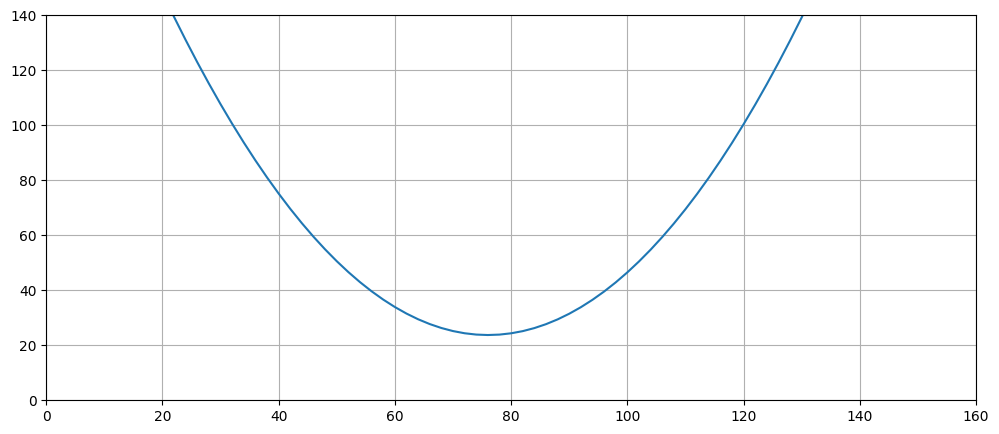

In [15]:
# Quadratic Normal Model parameters
sig_atm, a, b, c = 24.249067350166275, 228.66240029218525, -6.02888532189243, 0.039649083686508296

# plot sig(f)
sigma_qnm = lambda f : sig_atm + a + b*f + c*f**2
arr_f = np.arange(0,141,2)

plt.figure(figsize=(12,5))
plt.plot(arr_f, sigma_qnm(arr_f), label = f'{sig_atm}')

plt.xlim(0,160)
plt.ylim(0,140)
plt.grid()

plt.show()


In [16]:
# Quadratic Normal Model 1 (2023)

class QNM:
    def __init__(self, F, sig_atm, a, b, c, r, tau):
      self.F = F
      self.sig_atm = sig_atm
      self.a = a
      self.b = b
      self.c = c
      self.r = r
      self.tau = tau


    def option_pricer(self, K, option_type = 'call'):
      '''
      The method of linearization
      return call/put option price
      '''
      m = (self.F - K)/(self.sig_atm * self.tau**0.5)
      C_BC = np.exp(-self.r * self.tau) * ((self.F - K)*norm.cdf(m) + self.sig_atm * self.tau**0.5 * norm.pdf(m))
      P_BC = np.exp(-self.r * self.tau) * ((K - self.F)*(1-norm.cdf(m)) + self.sig_atm * self.tau**0.5 * norm.pdf(m))
      U = self.tau**0.5 * norm.pdf(m) * (self.a + self.b*(self.F + K)/2 +
                            self.c*(self.F**2 + self.F*K + K**2 + 0.5*self.sig_atm**2*self.tau)/3)

      if option_type == 'call':
          return C_BC + U*np.exp(-self.r * self.tau)
      elif option_type == 'put':
          return P_BC + U*np.exp(-self.r * self.tau)


    def simulate_F(self, paths = 10000, steps = None):
      '''
      Monte Carlo simulation
      return underlying futures price and time vector
      '''
      # default parameter
      if steps == None:
        steps = int(self.tau*252*10)

      # Initialize vectors
      arr_F = np.zeros((paths,steps))
      arr_F[:,0] = self.F

      # generate Brownian motion
      arr_w = np.random.standard_normal(size = (paths, steps-1))

      # compute the corresponding price
      t_vec, dt = np.linspace(0, self.tau, steps, retstep=True)
      vol_ = lambda f : self.sig_atm + self.a + self.b*f + self.c*f**2
      for t in range(0, steps-1):
          arr_F[:,t+1] = arr_F[:,t] + vol_(arr_F[:,t]) * dt**0.5 * arr_w[:,t]

      return arr_F, t_vec


    def implicit_FD(self, K, option_type = 'call'):
      '''
      The implicit finite difference
      return call/put option price
      '''
      # PDE: V_t + aV_ff + bV_f + cV = 0
      a = lambda f : 0.5 * (self.sig_atm + self.a + self.b*f + self.c*f**2)**2
      b = lambda f : 0
      c = lambda f : -self.r

      # Grid Parameters
      f_max = self.F + 100                                                        # space upper boundary
      f_min = self.F - 100                                                        # space lower boundary
      M = int(8*(f_max-f_min)) + 1                                                # the number of space steps
      N = int(100*252*self.tau)                                                   # the number of time steps

      # Grid Construction
      arr_f, df = np.linspace(f_min, f_max, M, retstep=True)                      # space discretization
      arr_t, dt = np.linspace(0, self.tau, N, retstep=True)                       # time discretization
      V = np.zeros((M, N))                                                        # grid initialization
      if option_type == 'call':
          V[:,0] = np.maximum(0, arr_f - K)                                       # European call option payoff (terminal condition)
          V[0,:] = 0                                                              # boundary condition
          V[-1,:] = (f_max - K) * np.exp(-self.r*arr_t)                           # boundary condition
      elif option_type == 'put':
          V[:,0] = np.maximum(0, K - arr_f)                                       # European put option payoff (terminal condition)
          V[0,:] = (K - f_min)* np.exp(-self.r*arr_t)                             # boundary condition
          V[-1,:] = 0                                                             # boundary condition

      # Tri-diagonal Matrix Construction
      alpha = lambda f : -a(f)*dt/df**2 + b(f)*dt/2/df
      beta = lambda f : 1 + 2*a(f)*dt/df**2 - c(f)*dt
      gamma = lambda f : -a(f)*dt/df**2 - b(f)*dt/2/df

      D = np.zeros(shape = (M-2,M-2))
      D[0,0], D[0,1], D[-1,-2], D[-1,-1] = beta(arr_f[1]), gamma(arr_f[1]), alpha(arr_f[-2]), beta(arr_f[-2])
      for m in range(1, M-3):
          D[m,m-1], D[m,m], D[m,m+1] = alpha(arr_f[m+1]), beta(arr_f[m+1]), gamma(arr_f[m+1])
      D = sparse.csr_matrix(D)

      # Grid Computation
      rem = np.zeros(shape = (M-2,))
      for n in range(1,N):
          rem[0], rem[-1] = alpha(arr_f[1])*V[0,n-1], gamma(arr_f[-2])*V[-1,n-1]
          V[1:-1,n] =  sparse.linalg.spsolve(D, V[1:-1, n-1] - rem)

      return V[ round( (self.F - f_min)/df), -1]


In [17]:
# QNM formula
qnm = QNM(futures_price, sig_atm, a, b, c, risk_free_rate, time_to_maturity)
qnm_call = qnm.option_pricer(K = strike_price, option_type = 'call')
qnm_put = qnm.option_pricer(K = strike_price, option_type = 'put')

print(f'QNM formula:')
print(f'call is {qnm_call:.4f}')
print(f'put is {qnm_put:.4f}')

QNM formula:
call is 1.0067
put is 7.2011


In [18]:
# Monte Carlo simulation
paths = 100000
arr_F, _ = qnm.simulate_F(paths = paths)

arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(arr_F[:,-1] - strike_price, 0)
qnm_call_mc, ste_call = arr_V.mean(), arr_V.std() / paths**0.5
arr_V = np.exp(-risk_free_rate*time_to_maturity) * np.maximum(strike_price - arr_F[:,-1], 0)
qnm_put_mc, ste_put = arr_V.mean(), arr_V.std() / paths**0.5

print(f'Monte Carlo simulation:')
print(f'call is {qnm_call_mc:.4f} with standard error {ste_call:.6f}')
print(f'put is {qnm_put_mc:.4f} with standard error {ste_put:.6f}')

Monte Carlo simulation:
call is 0.9918 with standard error 0.008728
put is 7.1967 with standard error 0.021902


In [19]:
# Finite difference method (implicit)
qnm_call_df = qnm.implicit_FD(K = strike_price, option_type = 'call')
qnm_put_fd = qnm.implicit_FD(K = strike_price, option_type = 'put')
print(f'Finite difference method (implicit):')
print(f'call is {qnm_call_df:.4f}')
print(f'put is {qnm_put_fd:.4f}')

Finite difference method (implicit):
call is 1.0058
put is 7.2001


## Option Prices across Models

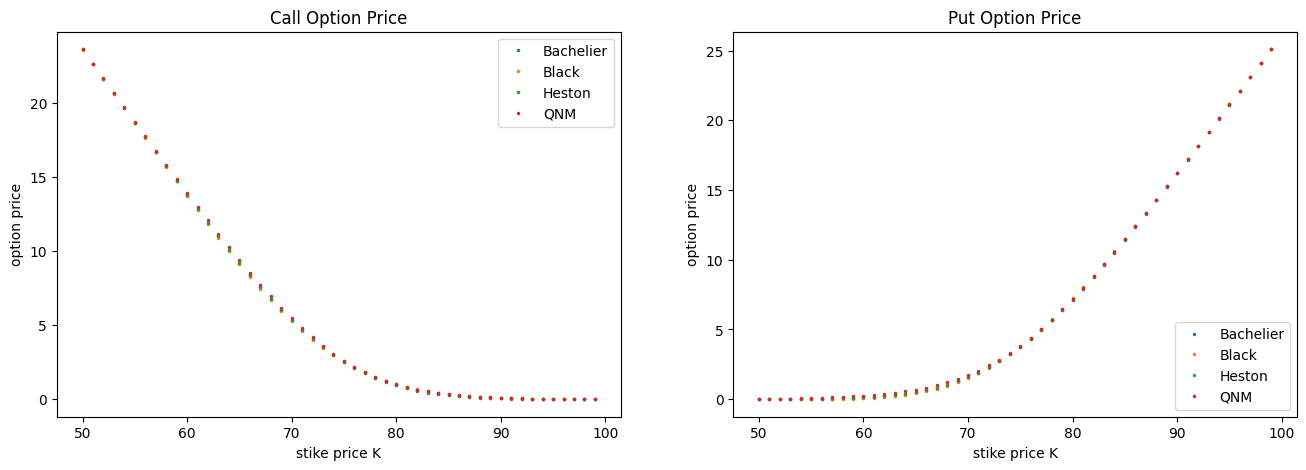

In [20]:
arr_strike = np.arange(50,100,1)

# call option
arr_bachelier_call = bachelier.option_pricer(K = arr_strike, option_type = 'call')
arr_black_call = black.option_pricer(K = arr_strike, option_type = 'call')
list_heston_call = []
list_qnm_call = []
for strike_ in arr_strike:
    list_heston_call.append(heston.option_pricer(K = strike_, option_type = 'call'))
arr_qnm_call = qnm.option_pricer(K = arr_strike, option_type = 'call')

# put option
arr_bachelier_put = bachelier.option_pricer(K = arr_strike, option_type = 'put')
arr_black_put = black.option_pricer(K = arr_strike, option_type = 'put')
list_heston_put = []
list_qnm_put = []
for strike_ in arr_strike:
  list_heston_put.append(heston.option_pricer(K = strike_, option_type = 'put'))
arr_qnm_put = qnm.option_pricer(K = arr_strike, option_type = 'put')


# create subplots
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.plot(arr_strike, arr_bachelier_call, '.', markersize=3, label = 'Bachelier')
ax1.plot(arr_strike, arr_black_call, '.', markersize=3, label = 'Black')
ax1.plot(arr_strike, list_heston_call, '.', markersize=3, label = 'Heston')
ax1.plot(arr_strike, arr_qnm_call, '.', markersize=3, label = 'QNM')
ax1.set_title('Call Option Price')
ax1.set_xlabel('stike price K')
ax1.set_ylabel('option price')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(122)
ax2.plot(arr_strike, arr_bachelier_put, '.', markersize=3, label = 'Bachelier')
ax2.plot(arr_strike, arr_black_put, '.', markersize=3, label = 'Black')
ax2.plot(arr_strike, list_heston_put, '.', markersize=3, label = 'Heston')
ax2.plot(arr_strike, arr_qnm_put, '.', markersize=3, label = 'QNM')
ax2.set_title('Put Option Price')
ax2.set_xlabel('stike price K')
ax2.set_ylabel('option price')
ax2.legend(loc='lower right')

plt.show()


## Implied Volatility

In [21]:
def implied_volatility(option_price, F, K, r, tau, option_type = 'call', model = 'black', method='brent', disp=True):
    """
        Return Implied volatility
        model: black (default), bachelier
        methods: brent (default), fsolve, minimization
    """
    # model
    if model == 'bachelier':
        bachelier_ = Bachelier(F, F*0.1, r, tau)
        obj_fun = lambda vol : option_price - bachelier_.option_pricer(K = K, vol = vol, option_type = option_type)
    else: # model == 'black'
        black_ = Black(F, 0.1, r, tau)
        obj_fun = lambda vol : option_price - black_.option_pricer(K = K, vol = vol, option_type = option_type)

    # numerical method
    if method == 'minimization':
        obj_square = lambda vol : obj_fun(vol)**2
        res = minimize_scalar( obj_square, bounds=(1e-15, 8), method='bounded')
        if res.success == True:
            return res.x

    elif method == 'fsolve':
        X0 = [0.1, 0.5, 1, 3]   # set of initial guess points
        for x0 in X0:
            x, _, solved, _ = fsolve(obj_fun, x0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    else:
        x, r = brentq( obj_fun, a = 1e-15, b = 500, full_output = True)
        if r.converged == True:
            return x


    # display strikes with failed convergence
    if disp == True:
        print(method, K)

    return -1


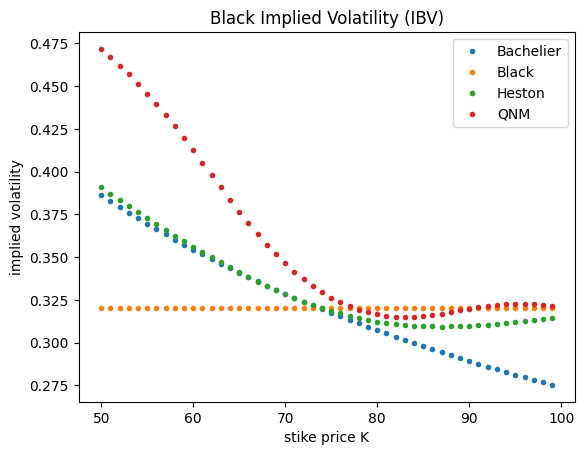

In [22]:
# Black implied volatility (IBV)
list_ibv_bachelier, list_ibv_black, list_ibv_heston, list_ibv_qnm = [], [], [], []
for stirke_, bachelier_, black_, heston_, qnm_ in zip(arr_strike, arr_bachelier_call, arr_black_call, list_heston_call, arr_qnm_call):
    list_ibv_bachelier.append(implied_volatility(bachelier_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))
    list_ibv_black.append(implied_volatility(black_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))
    list_ibv_heston.append(implied_volatility(heston_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))
    list_ibv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'black', method='brent', disp=True))

# create plot
plt.plot(arr_strike, list_ibv_bachelier, '.', label = 'Bachelier')
plt.plot(arr_strike, list_ibv_black, '.', label = 'Black')
plt.plot(arr_strike, list_ibv_heston, '.', label = 'Heston')
plt.plot(arr_strike, list_ibv_qnm, '.', label = 'QNM')
plt.title('Black Implied Volatility (IBV)')
plt.xlabel('stike price K')
plt.ylabel('implied volatility')
plt.legend(loc = 'upper right')
plt.show()


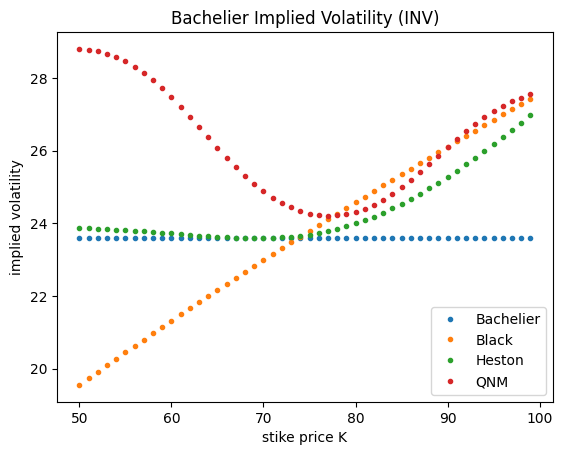

In [23]:
# Bachelier implied volatility (INV)
list_inv_bachelier, list_inv_black, list_inv_heston, list_inv_qnm = [], [], [], []
for stirke_, bachelier_, black_, heston_, qnm_ in zip(arr_strike, arr_bachelier_call, arr_black_call, list_heston_call, arr_qnm_call):
    list_inv_bachelier.append(implied_volatility(bachelier_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))
    list_inv_black.append(implied_volatility(black_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))
    list_inv_heston.append(implied_volatility(heston_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))
    list_inv_qnm.append(implied_volatility(qnm_, futures_price, stirke_, risk_free_rate, time_to_maturity,
                                                          option_type = 'call', model = 'bachelier', method='brent', disp=True))


plt.plot(arr_strike, list_inv_bachelier, '.', label = 'Bachelier')
plt.plot(arr_strike, list_inv_black, '.', label = 'Black')
plt.plot(arr_strike, list_inv_heston, '.', label = 'Heston')
plt.plot(arr_strike, list_inv_qnm, '.', label = 'QNM')
plt.title('Bachelier Implied Volatility (INV)')
plt.xlabel('stike price K')
plt.ylabel('implied volatility')
plt.legend(loc = 'lower right')
plt.show()


## Technicle note - Quadratic Normal Model

Consider an underlying futures price, $F_t$, with the following dynamics:

\begin{cases}
dF_t = \sigma(F_t)dW_t \\
\sigma(F_t) = \sigma_{ATM} + \epsilon(F_t)
\end{cases}

Here, $\epsilon$ represents a small perturbation that only depends on the space $F$.

Under the no-arbitrage condition, any derivative price $V(F, t)$ in this economy satisfies the following partial differential equation (PDE):

\begin{align*}
& \frac{\partial V}{\partial t} + \frac{(\sigma_{ATM} + \epsilon)^2}{2}\frac{\partial^2 V}{\partial F^2} = rV\\
\end{align*}

We are specifically interested in the European call option price, $C(F, t)$. We conjecture that $C = C_{BC} + e^{-r(T-t)}U$, where $C_{BC}$ is the Bachelier call formula. Substituting this into the above PDE, we obtain:

\begin{align*}
(\frac{\partial C_{BC}}{\partial t} + \frac{\sigma_{ATM}^2}{2}\frac{\partial^2 C_{BC}}{\partial F^2} - rC_{BC}) + e^{-r(T-t)}(\frac{\partial U}{\partial t} + \frac{\sigma_{ATM}^2}{2}\frac{\partial^2 U}{\partial F^2} + \epsilon\sigma_{ATM}\frac{\partial^2 C_{BC}e^{r(T-t)}}{\partial F^2}) + e^{-r(T-t)}(\frac{\epsilon^2}{2}\frac{\partial^2 C_{BC}e^{r(T-t)}}{\partial F^2} + (\epsilon\sigma_{ATM} + \frac{\epsilon^2}{2})\frac{\partial^2 U}{\partial F^2}) = 0
\end{align*}

The Bachelier formula $C_{BC}$ solves the first parenthesis. The terms grouped in the last parenthesis are of higher order with respect to $\epsilon$. Therefore, any $U$ satisfying the second parenthesis makes the PDE hold for some small perturbation $\epsilon$. Let's consider $\tau = T-t$ and $U = \sqrt{\tau}n\left(\frac{F-K}{\epsilon\sqrt{\tau}}\right)p(F, \tau)$. After changes of variables, the PDE is now transformed into the following:

\begin{align*}
p + \tau \frac{\partial p}{\partial \tau} - \frac{\sigma_{ATM}^2\tau}{2}\frac{\partial^2 p}{\partial F^2} + (F-K)\frac{\partial p}{\partial F} = \epsilon
\end{align*}

Let $\epsilon(F) = a + bF+cF^2$ and $p(F, \tau) = w_0 + w_1F + w_2F^2 + w_3\tau$. The PDE relates these two functions through a set of linear equations:

\begin{cases}
w_0 - Kw_1 = a \\
2w_1 - 2Kw_2 = b \\
3w_2 = c \\
2w_3 = \sigma_{ATM}^2w_2
\end{cases}

The solution to the above linear system is:
\begin{cases}
w_0 = a + \frac{Kb}{2} + \frac{K^2c}{3}\\
w_1 = \frac{b}{2} + \frac{Kc}{3}\\
w_2 = \frac{c}{3}\\
w_3 = \frac{\sigma_{ATM}^2c}{6}
\end{cases}

This method can be extended to accommodate higher-order polynomial volatility perturbation functions $\epsilon(F)$. In such cases, $p(F, \tau)$ should also be considered as a polynomial of the same order, with coefficients determined by matching the corresponding terms to ensure the satisfaction of the PDE.